# Analysing the Most Trending Hashtag in HYD Right Now

In [62]:
import sys
import tweepy
import json
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from operator import itemgetter
from scipy import stats
from io import StringIO
%matplotlib inline

all_tweets=[]
count_links=0
tweet_text=""
all_hashtags=set()
top_langs=[]
top_langs_numbers=[]
lang=set()
verified=0
langs={}
video=0
photo=0
gif=0
jsonfile=""

consumer_key = "DqjW4VdIPFv4fC7YWVGpJiqtG"
consumer_secret = "ojrpev2HJu2E2Du5YlSQjUu8W8frYgX6n3FCtJvqyr7GBrLSOX"
access_key = "929492088915337216-yP5PizbCfNMGVSJtt3OgIFlh3iJiB34"
access_secret = "06ZhcJo02h2dZclkugH04fdelLEppg151A3mq4x3FuJ2T"
count=0


def get_top_keyword_in_HYD(api):
    hyd_trend= api.trends_place(2295414)
    return str(hyd_trend[0]["trends"][0]['name'])

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
keyword = get_top_keyword_in_HYD(api)


class CustomStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        global count
        global all_tweets
        global langs
        global tweet_text
        global photo
        global video
        global gif
        global count_links
        global jsonfile
        try: 
            count+=1
            #print(f'\r{count}/200 received for analysis. Please wait while 200 tweets are collected', end= " ")
            jsonstring=json.dumps(status._json)
            if '"type": "video"' in jsonstring:
                video+=1
            if '"type": "photo"' in jsonstring:
                photo+=1
            if '"type": "GIF"' in jsonstring:
                gif+=1
            jsonobj = json.loads(jsonstring)
            dict={}
            dict['text']=jsonobj['text']
            if "https" in dict['text'] or "http" in dict['text'] :
                count_links+=1
            tweet_text= tweet_text + ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",jsonobj['text']).split())
            dict['clean_text']=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",dict['text']).split())
            dict['devices']=jsonobj['source']
            dict['in_reply_to_status_id']=jsonobj['in_reply_to_status_id']
            dict['verified']=jsonobj['user']['verified']
            lang= jsonobj['lang']
            if lang != "und":
                if lang in langs:
                    langs[lang]+=1
                else:
                    langs[lang]=1
            if dict['verified']== True:
                verified+=1
            dict['followers_count']=jsonobj['user']['followers_count']
            dict['listed_count']=jsonobj['user']['listed_count']
            dict['hashtags']=[hashes['text'] for hashes in jsonobj['entities']['hashtags']]
            all_tweets.append(dict)
            jsonfile=jsonfile + json.dumps(status._json)+"\n"
                
        except Exception as e:
            print(e)

        if(count==100):
            return False



    def on_error(self, status_code):
        print('Encountered error with status code:', status_code)
        return True

    def on_timeout(self):
        print( 'Timeout...')
        time.sleep(15*60)
        return True

print("The current most trending Hashtag is ",keyword)
sapi = tweepy.streaming.Stream(auth, CustomStreamListener())    
sapi.filter(track=[	keyword ])


while(count!=100):
    print(f'\r{count}/200 recieved for analysis', end= " ")
for tweet in all_tweets:
    for hashtag in tweet['hashtags']:
        all_hashtags.add(hashtag)
        langs={k: v for k, v in sorted(langs.items(), key=lambda item: item[1], reverse=True)}
        for lang,langcount in langs.items():
            top_langs.append(lang)
            top_langs_numbers.append(langcount)

#2MPostsForSidShuklaOnIG
200/200 recieved for analysis 

# Twitter Sentiment Analysis for the Hashtag

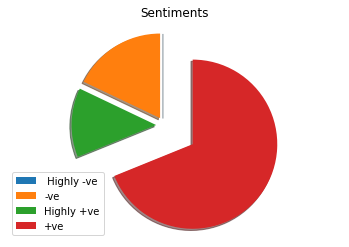

In [63]:
highly_negative=0
negative=0
neutral=0
positive=0
highly_positive=0
for tweet in all_tweets:
    analysis = TextBlob(tweet['clean_text'])
    if analysis.sentiment.polarity==0:
        neutral+=1
    elif analysis.sentiment.polarity > 0.5 and analysis.sentiment.polarity <=1:
        highly_positive+=1
    elif analysis.sentiment.polarity <= 0.5 and analysis.sentiment.polarity > 0:
        positive+=1
    elif analysis.sentiment.polarity < 0 and analysis.sentiment.polarity >= -0.5:
        negative+=1
    elif analysis.sentiment.polarity < -0.5 and analysis.sentiment.polarity >= -1:
        highly_negative+=1
        
labels = [' Highly -ve', '-ve', 'Highly +ve', '+ve']
sizes = [highly_negative, negative , highly_positive , positive]
explode = (0.1, 0.1, 0.1, 0.4)

fig, ax = plt.subplots()
patches,texts= ax.pie(sizes,
       explode=explode,
       shadow=True,
       startangle=90)
plt.legend(patches, labels, loc="best")
ax.axis('equal')
ax.set_title('Sentiments')


plt.show()

In [ ]:
tweets_df = pd.read_json(StringIO(jsonfile), lines=True) # we load the data into a pandas data frame. 
# This is useful as each JSON is new line after it has been generated from twitter.py
pd.set_option('display.float_format', lambda x: '%.f' % x)
# here we define the coloumns of the dataframe.. Collecting useful info
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count"])
equal_columns = ["created_at", "id", "text"]
# copy all relevent data
tweets_final[equal_columns] = tweets_df[equal_columns]
tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
tweets_final["in_reply_to_user_id"]= tweets_df["in_reply_to_user_id"]
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)
graph = nx.Graph()

# This function gets the interaction between the users. 
# Function that will iterate over the DataFrame, obtain the user_id and screen_name of the user that the author of 
# that specific tweet mention, reply or retweet. The function will return the user of the specific tweet together 
# with a list of the users with whom the user interacted.
def get_interactions(row):
    user = row["user_id"], row["screen_name"]
    if user[0] is None:
        return (None, None), []
    interactions = set()
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    interactions.discard((row["user_id"], row["screen_name"]))
    interactions.discard((None, None))
    return user, interactions

# Here we loop through the all tweets and call the get_interactions function to get the interactions.
# Then we build the graph.
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name
print(f"There are {graph.number_of_nodes()} Users and {graph.number_of_edges()} Interactions present in the Network")
degrees = [val for (node, val) in graph.degree()]
max_degrees=np.max(degrees)
min_degrees=np.min(degrees)
print(f"The Maximum Interaction in the Network is {max_degrees}")
print(f"The Minimum Interaction in the Network is {min_degrees}")
max_nodes=[node for (node, val) in graph.degree() if val==max_degrees]
print("The maximum Interaction is by Following User: ",max_nodes[0],api.get_user(max_nodes[0])["screen_name"])
print(f"The Average Level of Interaction in the Network is {np.mean(degrees):.1f}") 
print(f"There are {nx.number_connected_components(graph)} Connected Social Groups in the Network")
largest_subgraph = list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest social group")
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

# Network Analysis
There are three types of interactions between two Twitter users that we should gather: retweets, replies, and mentions. For this we plot a graph of these interactions. An edge exists in the graph if there has been an interaction between these users. The below information is very useful for analysing the network. Also there is plot of the largest connected component of graph. 

In [65]:
print(f"The Biggest Distance Between two Users in the network is {nx.diameter(largest_subgraph)}")
print(f"The Average Distance between any two Users is {nx.average_shortest_path_length(largest_subgraph):.2f}")
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"The User with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum in the network")
print(f"The User with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum in the network")
print(f"The User with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum in the network")

The Biggest Distance Between two Users in the network is 15
The Average Distance between any two Users is 5.94
The User with id 40867791 has a degree centrality of 0.09 which is the maximum in the network
The User with id 1065155822643101696 has a closeness centrality of 0.24 which is the maximum in the network
The User with id 1088386324279816192 has a betweenness centrality of 0.44 which is the maximum in the network


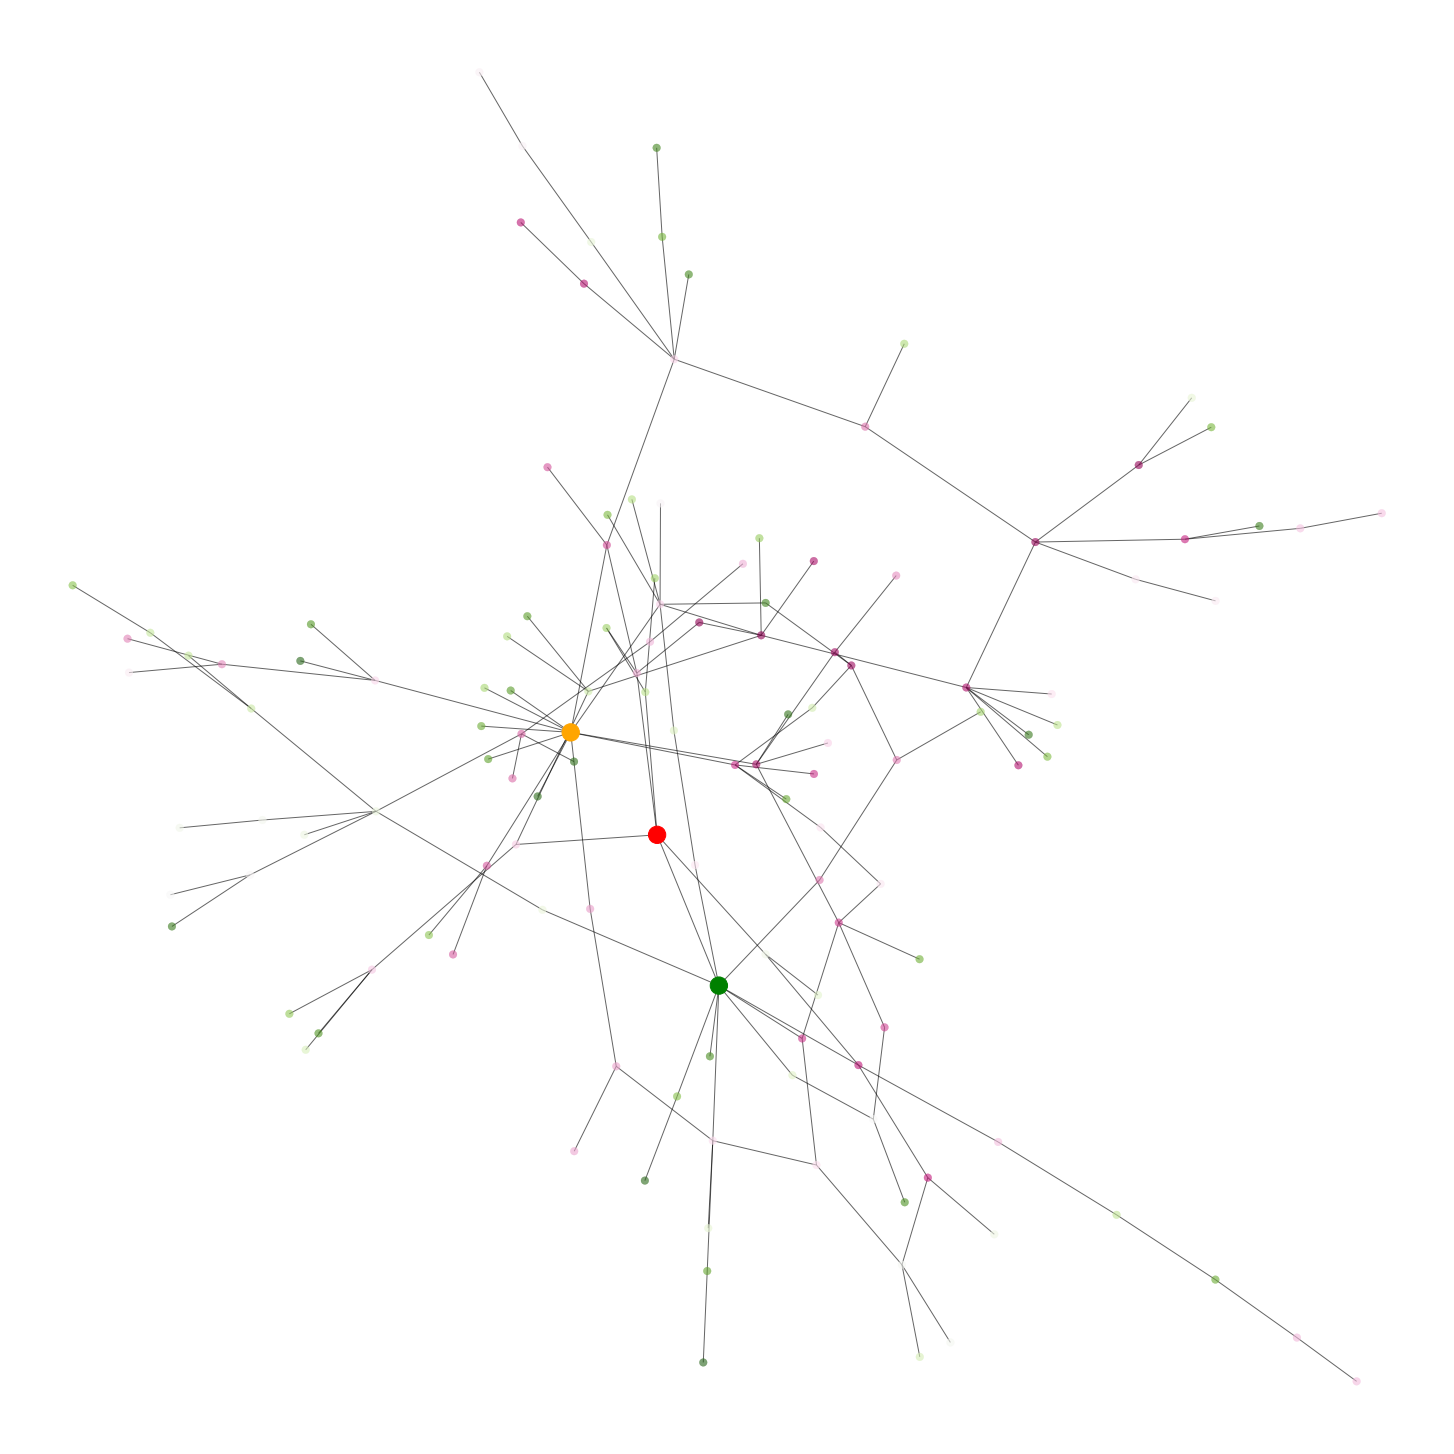

In [67]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange','red','green']
central_nodes = [max_de[0],max_clo[0],max_bet[0]]
pos = nx.spring_layout(largest_subgraph, k=0.05)
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(largest_subgraph.number_of_nodes()), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.show()

# Language Corpus

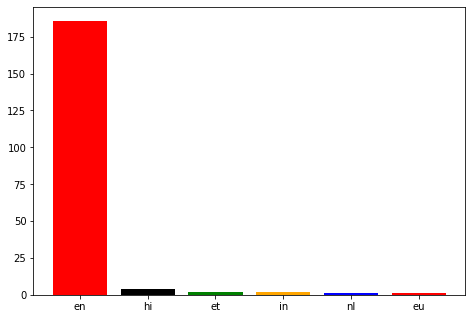

In [68]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(top_langs[:6],top_langs_numbers[:6],color=['red', 'black', 'green', 'orange', 'blue'])
plt.show()

# Word Cloud

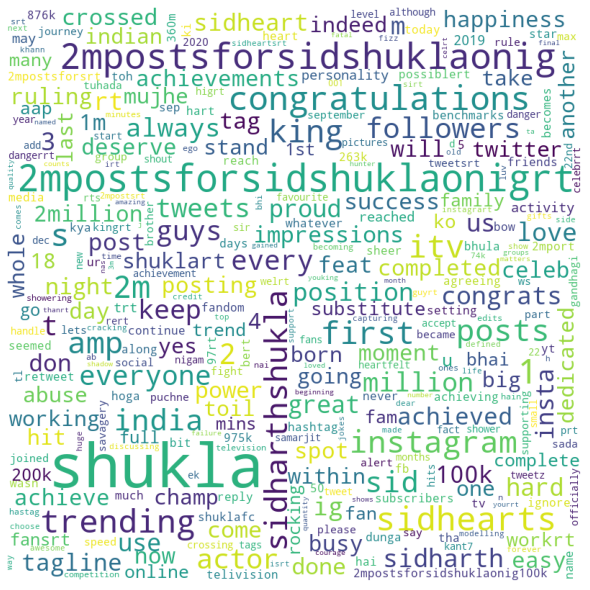

In [69]:
comment_words = ' '
stopwords = set(STOPWORDS) 
tokens = tweet_text.split()
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower()
for words in tokens: 
    if words not in stopwords: 
        comment_words = comment_words + words + ' '
counts = {}
for word in comment_words.split():
    if word in counts:
        counts[word] += 1
    else:
        counts[word] = 1
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=1000,
                relative_scaling=0.21,
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(counts)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

## Other Observations

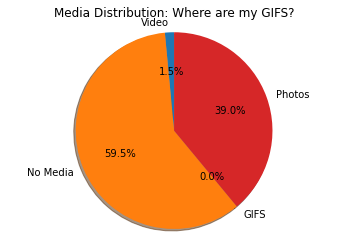

In [71]:
labels = [  'Video', "No Media",'GIFS','Photos']
sizes = [video, len(all_tweets)-video-gif-photo,gif,photo]

fig, ax = plt.subplots()
ax.pie(sizes,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')
ax.set_title('Media Distribution: Where are my GIFS?')


plt.show()

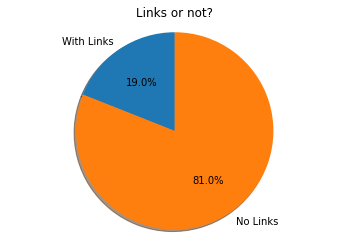

In [70]:
labels = ['With Links', 'No Links']
sizes = [count_links, len(all_tweets)-count_links]

fig, ax = plt.subplots()
ax.pie(sizes,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')
ax.set_title('Links or not?')


plt.show()